# Segmentation using FCN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torch
from torchview import draw_graph
from torchvision.transforms.functional import to_pil_image

def segment_image(model, weights, image_path, target='bird', device=None):   

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Step 1: Load image
    img = read_image(image_path)
    # plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')
    plt.imshow(img.permute(1, 2, 0)  )
    plt.axis('off')  
    plt.show()

    model=model.to(device)
    model.eval()
    
    # Step 2: Initialize the inference transforms
    preprocess = weights.transforms()
    
    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(img).unsqueeze(0).to(device)
    
    # Step 4: Use the model and print the predicted category
    prediction = model(batch)["out"]
    normalized_masks = prediction.softmax(dim=1)
    class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
    mask = normalized_masks[0, class_to_idx[target]]
    mask_img = to_pil_image(mask)
    plt.imshow(mask_img, cmap='gray')
    plt.axis('off')
    plt.show()

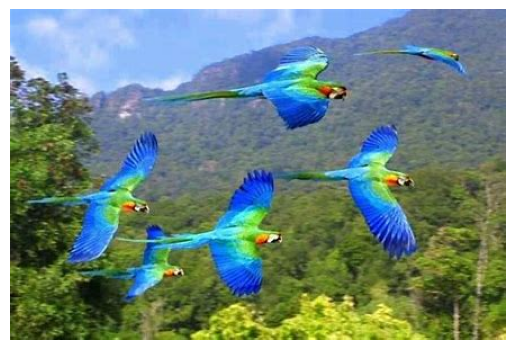

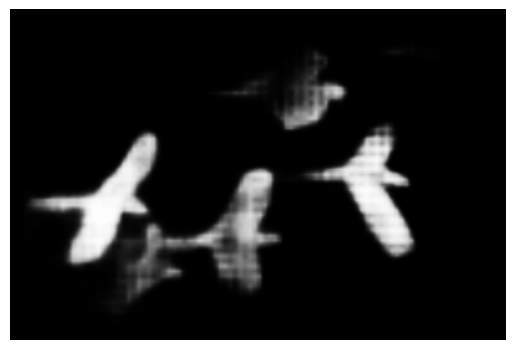


(dot.exe:41256): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


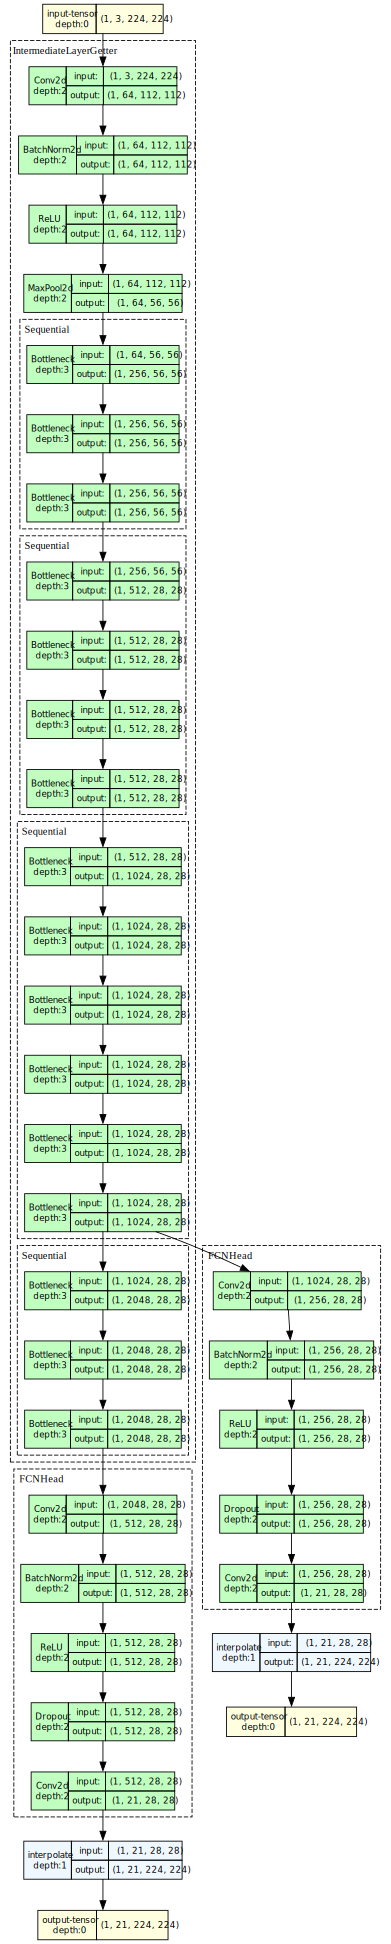

In [2]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchview import draw_graph

weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
segment_image(model, weights, 'parrot.jpg', target='bird')

model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True) # device='meta'
model_graph.visual_graph

# Segmentation using DeepLabV3-MobileNet

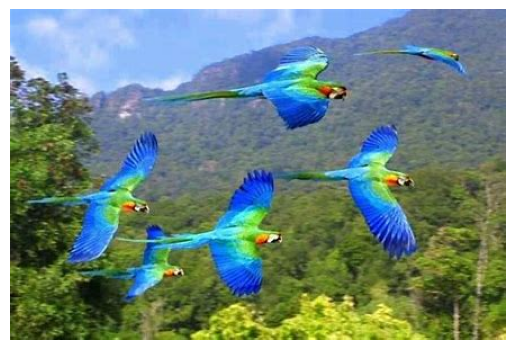

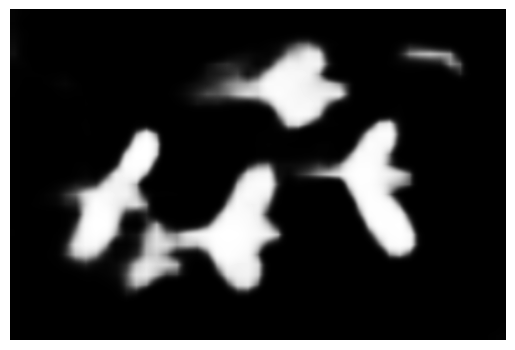


(dot.exe:56432): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


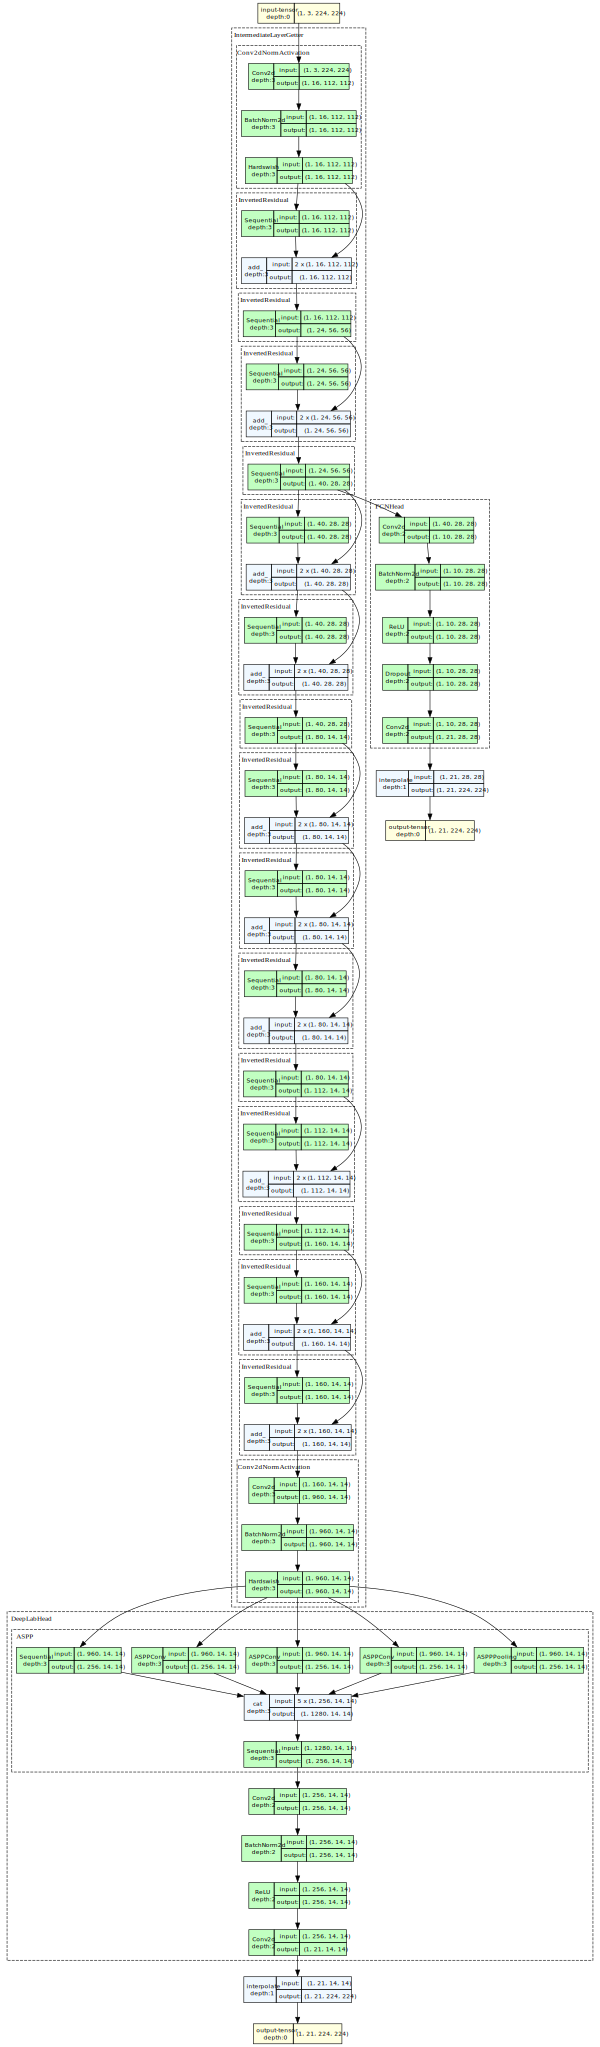

In [3]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=weights)
segment_image(model, weights, 'parrot.jpg', target='bird')

model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True) # device='meta'
model_graph.visual_graph

## Instance Segmentation using Mask-RCNN

In [4]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks
from torchview import draw_graph

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

img = read_image('parrot.jpg')
images = [transforms(d) for d in [img]]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)
masks = output[0]['masks']

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

shape = torch.Size([22, 1, 294, 441]), dtype = torch.bool


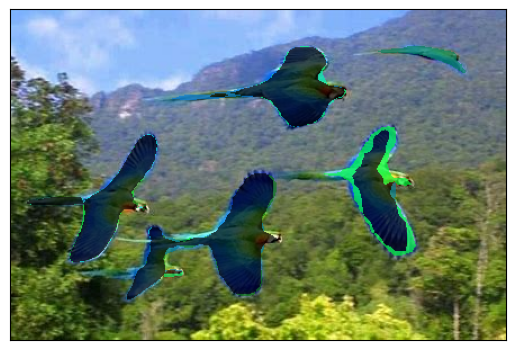

In [6]:
proba_threshold = 0.8
bool_masks = masks > proba_threshold
print(f"shape = {bool_masks.shape}, dtype = {bool_masks.dtype}")

# There's an extra dimension (1) to the masks. We need to remove it
bool_masks = bool_masks.squeeze(1)

show(draw_segmentation_masks(img, bool_masks, alpha=0.7))